### RWSE-Checker: true-positives statistics from balanced corpus

In [1]:
from cassis import Cas, load_typesystem
from rwse import RWSE_Checker
from util.helper import collect_sentences_by_confusion_sets, normalize_report, replace_confusion_set_words_in_sentences

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

#### Load sentences by confusion sets

In [3]:
file_name = 'input/eng_news_2023-balanced-sentences.csv'

with open(file_name, 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

nlp = spacy.load('en_core_web_sm')
sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned,nlp)

total = 0

for key, value in sorted(sentences_by_confusion_sets.items()):
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Being,begin,being = 213
Capital,Capitol,capital = 111
Country,County,country,county = 168
Desert,desert,dessert = 101
Easy,ease,easy = 111
Effect,affect,effect = 118
Effects,affects,effects = 105
Except,accept,except = 105
Few,View,few,view = 168
Form,From,form,from = 643
Found,Fund,found,fund = 160
Fourth,forth,fourth = 117
Hole,Whole,hole,whole = 110
Lead,Led,lead,led = 146
Life,Live,life,live = 172
Mad,Made,mad,made = 169
Or,or,ore = 325
Past,passed,past = 127
Peace,Piece,peace,piece = 109
Plain,plain,plane = 104
Principal,principal,principle = 102
Provence,Province,province = 101
Quiet,Quite,quiet,quite = 110
Rise,raise,rise = 105
Safe,Save,safe,save = 120
Site,sight,site = 116
Split,spit,split = 101
Than,Then,than,then = 276
Their,There,They,their,there,they = 654
Them,Theme,them,theme = 178
Things,things,thinks = 115
Three,Tree,three,tree = 166
To,Too,Two,to,too,two = 2463
Trail,Trial,trail,trial = 109
Weather,Whether,weather,whether = 119
Week,weak,week = 151
Were,Where,were,whe

#### Switch confusion words in sentences

In [4]:
file_name = 'output/falsified_eng_new_2023-balanced-sentences.pkl'

if not os.path.exists(file_name):
    nlp = spacy.load("en_core_web_sm")
    modified_sentences_by_confusion_sets = replace_confusion_set_words_in_sentences(sentences_by_confusion_sets, nlp)
    with open(file_name, 'wb') as f:
        pickle.dump(modified_sentences_by_confusion_sets, f)
else:
    modified_sentences_by_confusion_sets = pickle.load(open(file_name, 'rb'))


total = 0
for key, value in modified_sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 140
advice,advise = 105
Effect,affect,effect = 157
Being,begin,being = 261
bitch,pitch = 108
brakes,breaks = 103
Capital,Capitol,capital = 146
Site,sight,site = 158
Country,County,country,county = 352
crab,crap = 102
Desert,desert,dessert = 137
Easy,ease,easy = 149
Effects,affects,effects = 144
extend,extent = 102
feat,feet = 116
Few,View,few,view = 344
Form,From,form,from = 1414
Fourth,forth,fourth = 154
forms,forums = 102
Found,Fund,found,fund = 338
Lead,Led,lead,led = 298
Life,Live,life,live = 370
loose,lose = 104
Mad,Made,mad,made = 346
Or,or,ore = 390
Past,passed,past = 164
Peace,Piece,peace,piece = 228
Plain,plain,plane = 143
Principal,principal,principle = 137
Provence,Province,province = 116
Quiet,Quite,quiet,quite = 220
Rise,raise,rise = 145
Safe,Save,safe,save = 250
Split,spit,split = 139
Than,Then,than,then = 572
Their,There,They,their,there,they = 3092
Them,Theme,them,theme = 378
Things,things,thinks = 159
Trail,Trial,trail,trial = 228
Three,Tree,thre

#### Determine RWSEs

In [5]:
T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

In [44]:
file_name = 'output/report_true_positives_balanced.csv'

result = dict()

if not os.path.exists(file_name):
    with open('output/false_negatives_balanced.csv', 'w') as f:
        for confusion_set, box in modified_sentences_by_confusion_sets.items():
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            matches = 0
            for item in box:
                cas = Cas(ts)
                sentence = item['sentence']
                # TODO clean sentence?
                cas.sofa_string = sentence
                doc = nlp(cas.sofa_string)
                cas_sentence = S(begin=0, end=len(sentence))
                cas.add(cas_sentence)
                for token in doc:
                    cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                    cas.add(cas_token)
                rwse.check_cas(cas, ts)
                true_positives = cas.select(T_RWSE)
                if len(true_positives) == 0:
                    before = sentence[item['new_token']['begin']:item['new_token']['end']]
                    modified_string = sentence[:item['new_token']['begin']] + ' [[' + item['new_token']['word'] + ']] ' + sentence[item['new_token']['end']:]
                    print(f"expected suggestion: {item['org_word']}", f"for token: {item['new_token']['word']}" , modified_string, sep='\t', file=f)
                else:
                    matches += 1
            result[confusion_set] = {
                'num_sentences':len(box),
                'num_matches':matches,
            }

    with open(file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key, value in result.items():
            print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
else:
    with open(file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            print(confusion_set, num_matches, num_sentences, sep='\t', end='\n')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}

Except,accept,except	140	140
advice,advise	97	105
Effect,affect,effect	148	157
Being,begin,being	260	261
bitch,pitch	97	108
brakes,breaks	92	103
Capital,Capitol,capital	128	146
Site,sight,site	153	158
Country,County,country,county	320	352
crab,crap	89	102
Desert,desert,dessert	132	137
Easy,ease,easy	148	149
Effects,affects,effects	142	144
extend,extent	100	102
feat,feet	115	116
Few,View,few,view	340	344
Form,From,form,from	1406	1414
Fourth,forth,fourth	154	154
forms,forums	87	102
Found,Fund,found,fund	333	338
Lead,Led,lead,led	275	298
Life,Live,life,live	345	370
loose,lose	102	104
Mad,Made,mad,made	329	346
Or,or,ore	378	390
Past,passed,past	159	164
Peace,Piece,peace,piece	220	228
Plain,plain,plane	134	143
Principal,principal,principle	124	137
Provence,Province,province	112	116
Quiet,Quite,quiet,quite	213	220
Rise,raise,rise	129	145
Safe,Save,safe,save	224	250
Split,spit,split	116	139
Than,Then,than,then	563	572
Their,There,They,their,there,they	3004	3092
Them,Theme,them,theme	366	378
T

#### Determine Sensitivity (True-Positive-Rate)

In [45]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'true positive rate: {total_matches/total:.2f}')
print(f'correctly identified {total_matches} out of {total}')

true positive rate: 0.98
correctly identified 30548 out of 31317


<Axes: xlabel='confusion_set'>

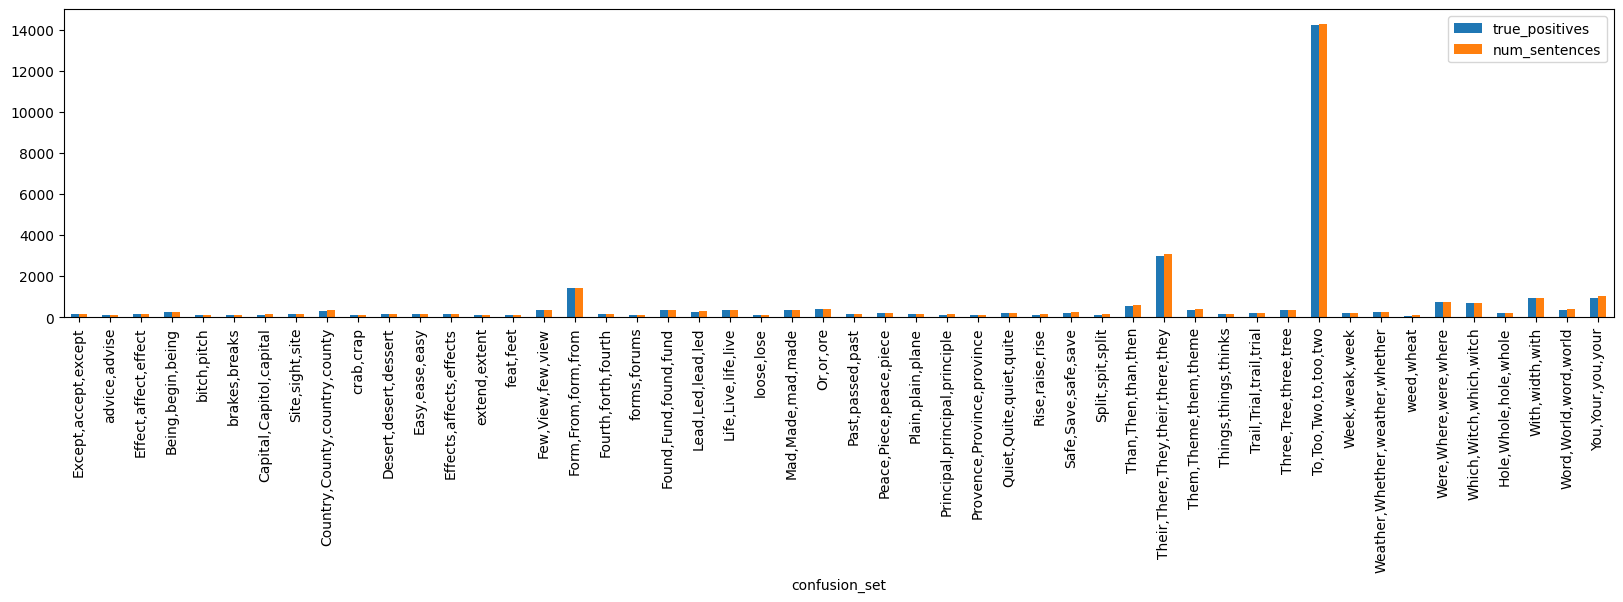

In [46]:
tp_df = pd.read_csv(file_name, sep=';')
tp_df.columns = ['confusion_set', 'true_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

#### Determine Mean Sensitivity

In [2]:
file_name = 'output/report_true_positives_balanced.csv'

data_mean_sensitivity = normalize_report(file_name)

mean_sensitivity = sum(data_mean_sensitivity.values())/ len(data_mean_sensitivity)

print(f'Mean Sensitivity = {mean_sensitivity:.10f}')

Mean Sensitivity = 0.9464505568


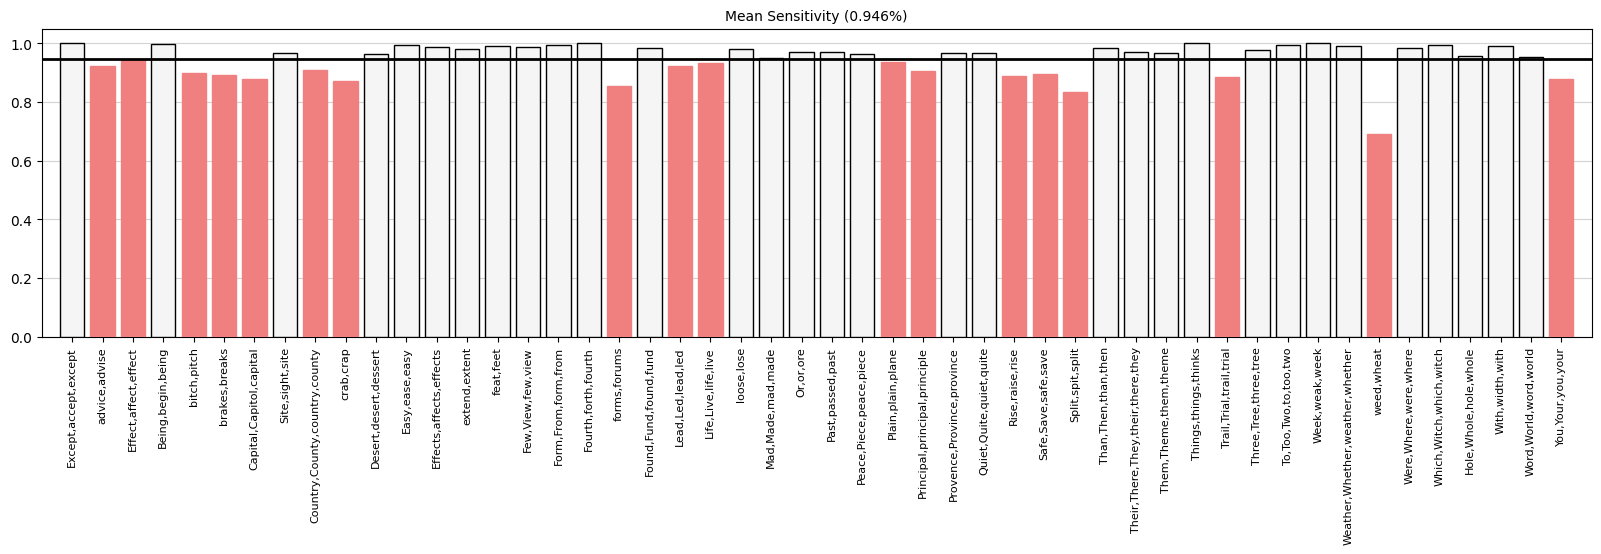

In [3]:
xticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
#ax.plot(xticks,[mean_sensitivity]*len(xticks), zorder=3, color="black", linewidth=1)
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_sensitivity))
y = [mean_sensitivity]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

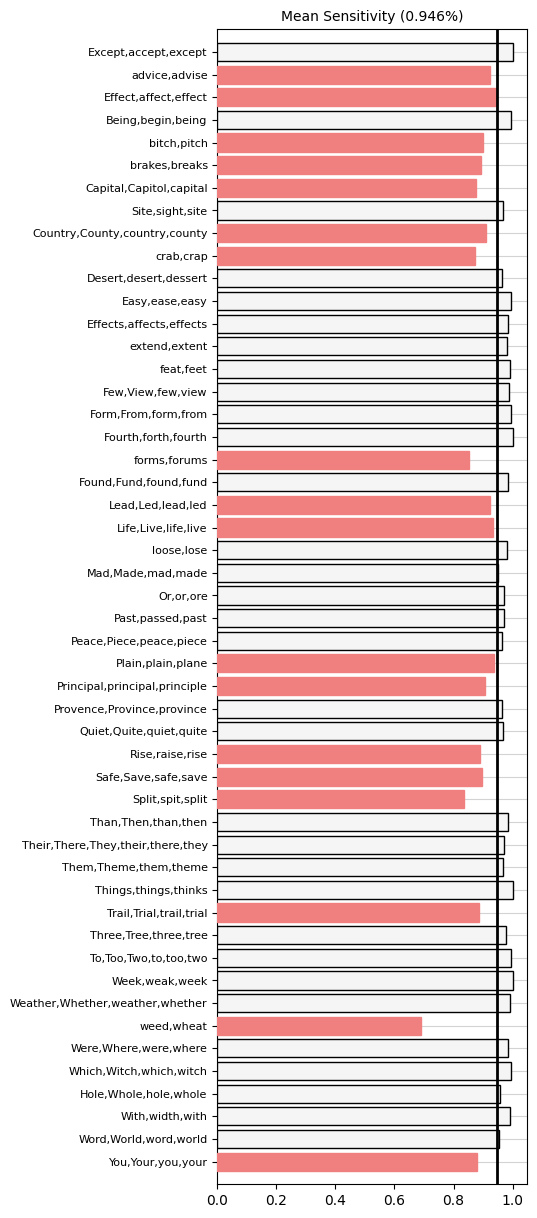

In [51]:
yticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_sensitivity]*len(x)
y = np.linspace(-1, len(data_mean_sensitivity))
ax.plot(x, y, zorder=3, color="black", linewidth=2)